<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Advanced Algortihm 1: Simple Ensemble Average Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Define a Simple Ensemble Average Classifier](#define-ensemble-function)  
&nbsp;&nbsp;&nbsp;[Ensemble the Top Models](#ensemble-top-models)  
&nbsp;&nbsp;&nbsp;[Average All Predictions](#average-preds)  
[Compare to Top Models](#compare)  
[Summary](#summary)

# Simple Ensemble Average Classifier Introduction <a class="anchor" id="introduction"></a>

Ensembling is a technique to combine multiple different kinds of classifiers. For example, you may want to combine a logistic regression and a random forest. There are many techniques that can be used to combine classifiers, of which averaging is the most straightforward. Ensembling is a common technique, and ensembles often perform better than individual model classes because one model can correct for another's error.

Constructing a simple ensemble average requires nothing more than predictions from more than one model. Combining predictions from multiple models offers a way of introducing heterogeneity of functional forms into a model pipeline without much additional complexity: one model may excel at utilizing certain patterns in the data, but be easily fooled by other patterns, while another model may have just the opposite properties. By combining the predictions from both, their best aspects can be amplified while their less helpful aspects can be mitigated.

In this notebook we will consider a simple (non-weighted) ensemble average of the top 10 models as ranked by their perforamnce on the Indonesia data. These models not only offer a variety of model classes, but have also been trained using various class-weighting techniques (under-sampling and over-sampling), which provides another level of heterogeneity.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** The component models of a simple ensemble average can have any properties, as long as they produce similarly structured predictions. The predictions from each model are then combined by some function to reduce the set of predictions to a single predicted output for each sample. 

**Algorithm and Training.** We will use the predicted class probabilities as the inputs to a standard arathmetic `mean` function so that each sample $i$ has $N$ predicted class probabilities, one from each of the $N$ models in the ensemble. Each component model is independently trained.


**Variations of the model.** If class probabilities are unavailable, then another technique such as "majority vote" could be used to reduce the set of predictions to one for each sample. Further, there are more advanced ways of ensembling such as _stacking_, in which predictions from the ensemble are used as input to another "second level" model. We will explore model stacking in the next notebook.

## Considerations <a class="anchor" id="introduction-considerations"></a>

Ensembling works best when the component models are heterogeneous. If very slight variations of the same model are used as the components in an ensemble, results are expected to be similar to those of a single model.

# Data setup <a class="anchor" id="setup"></a>

Since this type of ensembling relies on already-trained models, we could simply load the test data, models, predict, and combine. However, we will be using the prdictions from all models later in this series of notebooks. Therefore we will load the training and test data, and generate and save predictions from all samples.

First we load the standard libraries and data.

In [1]:
%matplotlib inline

import os
import sys
import json
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from visualization import visualize
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'ensemble'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

Using TensorFlow backend.


In [2]:
# load data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_test, y_test, w_test = load_data(TEST_PATH)

# Define a Simple Ensemble Averaging Model <a class="anchor" id="define-ensemble-function"></a>

To create an ensembled model, we'll need the predictions from the models that we want to include in the ensemble. We create a function `get_predictions_from_models` that will take a list of model names (that reference saved versions generated by other notebooks in this project) and creates a dataframe of the predictions the models make.

In [3]:
def get_predictions_from_models(list_of_models):
    # load the data
    country_dir = Path(evaluation.MODELS_DIR, COUNTRY)
    models = [evaluation.load_model(str(f.stem), COUNTRY)
              for f in country_dir.iterdir() if f.stem in list_of_models]
    
    # make predictions on training set
    all_preds_train = pd.DataFrame(np.zeros((X_train.shape[0], len(list_of_models))),
                             index=X_train.index,
                             columns=list_of_models).astype(float)
    all_preds_test = pd.DataFrame(np.zeros((X_test.shape[0], len(list_of_models))),
                             index=X_test.index,
                             columns=list_of_models).astype(float)
    
    # make preds on train and test
    for model in models:
        if 'feat' in model['name']:
            reduced_feat = model['features'].index.values
            X_train_reduced = X_train[reduced_feat]
            X_test_reduced = X_test[reduced_feat]
            all_preds_train[model['name']] = model['model'].predict_proba(X_train_reduced.as_matrix())[:, 1]
            all_preds_test[model['name']] = model['model'].predict_proba(X_test_reduced.as_matrix())[:, 1]
        else:
            all_preds_train[model['name']] = model['model'].predict_proba(X_train.as_matrix())[:, 1]
            all_preds_test[model['name']] = model['model'].predict_proba(X_test.as_matrix())[:, 1]

    
    # return all predictions for further evaluation
    return all_preds_train, all_preds_test

## Ensemble the Top Models <a class="anchor" id="ensemble-top-models"></a>

Here we pass a list of the top performing models to our ensembling generator, as determined by the comparisons presented in the results notebooks before this one.

Note that although some algorithm classes appear more than once, e.g., logistic regression (`lr`) and multi-layer-perception (`mlp`), each instance is different: some use over-sampling while some don't, some use cross-validation while some don't. This varition in training approaches should give us the heterogeneity we seek in a good ensemble model.

In [4]:
# top models selected from results notebook prior to this one
top_10 = [
    'lr_full_oversample',
    'mlp_full_undersample_cv',
    'lr_full_oversample_cv',
    'xgb_full_undersample_cv',
    'lr_full_undersample',
    'lr_full_classwts',
    'mlp_full_undersample',
    'lda_full_oversample_cv',
    'lr_l1_feats_oversample_cv',
    'lda_full_oversample',
]

Generate the prediction dataframe

In [5]:
all_preds_train, all_preds_test = get_predictions_from_models(top_10)

## Average All Predictions <a class="anchor" id="average-preds"></a>

As we can see here, we now have the probabilities that each model predicted for each household.

In [6]:
all_preds_test.head()

,lr_full_oversample,mlp_full_undersample_cv,lr_full_oversample_cv,xgb_full_undersample_cv,lr_full_undersample,lr_full_classwts,mlp_full_undersample,lda_full_oversample_cv,lr_l1_feats_oversample_cv,lda_full_oversample
hid,,,,,,,,,,
3521040202950202,2.259811e-01,0.135724,1.982971e-01,0.229414,0.169370,1.467828e-01,1.528176e-04,0.330846,0.335236,0.291907
6310020200930608,3.766187e-08,0.000031,2.247215e-08,0.000522,0.000004,9.262122e-07,4.023252e-21,0.001535,0.000742,0.001681
7310010200370305,2.728485e-06,0.000011,2.372742e-06,0.000088,0.000064,1.038306e-05,2.758182e-12,0.000230,0.000245,0.000227
3372030150640309,2.690712e-02,0.005942,2.329749e-02,0.010038,0.017010,4.482004e-02,2.120000e-09,0.054705,0.056535,0.069855
1213160203750307,1.828366e-04,0.001254,1.120742e-04,0.008949,0.000601,1.985433e-03,1.033493e-05,0.001213,0.007659,0.001105


To generate a single prediction for each household, we take the mean over the columns (`axis=1`) of our prediction `DataFrame`. This is the simple averaging of predictions that creates the ensemble.

In [7]:
# round predictions to generate class predictions (using a 0.5 threshold)
simple_ensemble_preds = all_preds_test.mean(axis=1).round() 

# take mean of predictions to generate class probabilties
simple_ensemble_prob = all_preds_test.mean(axis=1)

A version of this function that has been included in the `src/models/ensemble` directory, and this version creates all the individual model predictions and also returns the mean of predictions (as we've done manually here).

#### Poverty rate comparison

We can use the predictions generated by the ensemble to calculate the actual poverty rate and the predicted poverty rate.

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Make the ensemble predictions for train and test sets
ensemble_train = all_preds_train.mean(axis=1).round()
ensemble_test = all_preds_test.mean(axis=1).round()

# dataframe of the components needed for poverty rate prediction
pov_rate = pd.DataFrame(dict(
    wta_pop=np.concatenate([w_train, w_test]),
    poor=np.concatenate([y_train, y_test]),
    pred=np.concatenate([ensemble_train, ensemble_test])
))

pov_rate_actual = (pov_rate.wta_pop * pov_rate.poor).sum() / pov_rate.wta_pop.sum()

# Make predictions on entire dataset to get the predicted poverty rate
pov_rate_pred = (pov_rate.wta_pop * pov_rate.pred).sum() / pov_rate.wta_pop.sum()

print("\nActual poverty rate: {:0.2%} ".format(pov_rate_actual))
print("Predicted poverty rate: {:0.2%} ".format(pov_rate_pred))


Actual poverty rate: 11.38% 
Predicted poverty rate: 23.88% 


# Compare to Top Models <a class="anchor" id="compare"></a>

To gain a sense of the advantage of ensembling, let's compare the simple ensemble average to the performance of some of its component models. In order to avoid clutter in the plot, we have chosen only the top three models from the `top_10` list.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


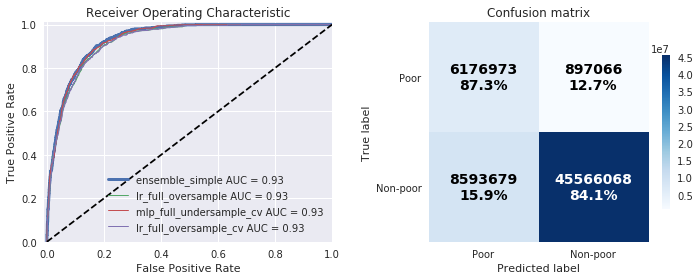

,ensemble_simple,lr_full_oversample,mlp_full_undersample_cv,lr_full_oversample_cv
accuracy,0.845008,0.854459,0.857694,0.851611
recall,0.873189,0.843033,0.854518,0.838116
precision,0.418192,0.433238,0.44028,0.427456
f1,0.565535,0.572346,0.581136,0.566159
cross_entropy,0.34436,0.344135,0.308514,0.348544
roc_auc,0.93394,0.926334,0.932805,0.925356
cohen_kappa,0.464792,0.473514,0.481756,0.471316


In [10]:
to_compare = ['lr_full_oversample', 'mlp_full_undersample_cv', 'lr_full_oversample_cv']
metrics = evaluation.evaluate_model(y_test, simple_ensemble_preds, simple_ensemble_prob, w_test, 
                                    compare_models=to_compare,
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    predict_pov_rate=False,
                                   )

The simple ensemble average leads the group in area under the roc curve. However, the component models still outperform the ensemble in other metrics (recall not all components are shown here).

Let's see how the ensemble holds up against all of its component models.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


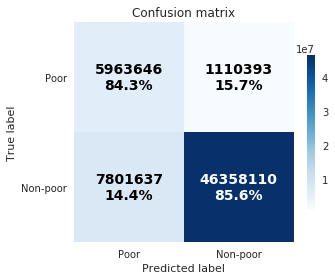

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,mean_rank
mlp_full_undersample_cv,0.857694,0.854518,0.44028,0.581136,0.308514,0.932805,0.481756,2.14286
lr_full_oversample,0.854459,0.843033,0.433238,0.572346,0.344135,0.926334,0.473514,3.28571
ensemble_simple,0.845008,0.873189,0.418192,0.565535,0.34436,0.93394,0.464792,3.57143
lr_full_oversample_cv,0.851611,0.838116,0.427456,0.566159,0.348544,0.925356,0.471316,4.57143
xgb_full_undersample_cv,0.835837,0.87632,0.403156,0.552247,0.366854,0.928831,0.453724,4.57143
lr_full_undersample,0.830133,0.883593,0.394889,0.545836,0.392892,0.926233,0.44493,6
lr_full_classwts,0.830513,0.866754,0.39387,0.541618,0.384733,0.923196,0.428159,6.85714
lda_full_oversample,0.815948,0.8906,0.375087,0.52786,0.424324,0.921219,0.408593,8.28571
mlp_full_undersample,0.82712,0.857794,0.387781,0.534109,0.831168,0.919972,0.441922,8.71429
lda_full_oversample_cv,0.813904,0.886697,0.371896,0.524012,0.426183,0.92172,0.406539,9


In [11]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in top_10  + ['ensemble_simple']]
result = visualize.display_model_comparison(metrics, rank_order=True, transpose=True)

When we compare the ensemble to _all_ of its component models, we see that its rank outperforms its components on average. 

# Summary <a class="anchor" id="summary"></a>

If you already have a collection of trained models for some data set, the simple ensemble average is a relatively easy way to probably improve the overall performance of your classification pipeline.